# ASL alphabet modeling
This project aims to train a model to recognize the ASL alphabet. Inclusivity is a massive concern for modern society, and unfortunately, ASL translators aren't available to anyone. We hope this project is a step in the right direction. For that task, we will create a Convolutional Neural Network (CNN) that gets the images and trains a model based on labels. We then test the model against the test fold with images that the model has never seen to calculate the efficiency.

## Imports
We started by importing the packages needed to build our model. We will use the TensorFlow and Keras packages to add layers to our model. We will also use metaplot and Seaborn to plot our visualizations.

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import skimage
from skimage.transform import resize
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, layers, models

2024-08-14 02:09:52.259592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 02:09:52.259704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 02:09:52.393909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Uploads
We started by importing the images from the training fold. Both folds can be found at https://www.kaggle.com/datasets/grassknoted/asl-alphabet. We then extracted those images and created the labels based on the letters they represent. To create our X and Y, we inspired our code on the Naman Manchanda, which loops over each subfolder and allocates the correct labels.

In [2]:
data ='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/'

def get_data(folder):
    target_dims = (64, 64, 3)
    train_len = 87000
    X = np.empty((train_len, 64, 64, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=int)
    cnt = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            else:
                label = 29
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (64, 64 , 3))
                    img_arr = np.asarray(img_file).reshape((-1, 64, 64, 3))
                    
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y

In [3]:
X, y = get_data(data)

In [7]:
y =  to_categorical(y,29)
y = np.argmax(y, axis=1)

## Exploratory Data Analyses
We will start by observing how the data we have available behave and whether there is any evidence that we could be dealing with some overfitting. We will also look for letters that are more common than others. We want to see the shape of the y and X arrays to confirm that we have the same number of impressions on both.

Text(0, 0.5, 'Labels')

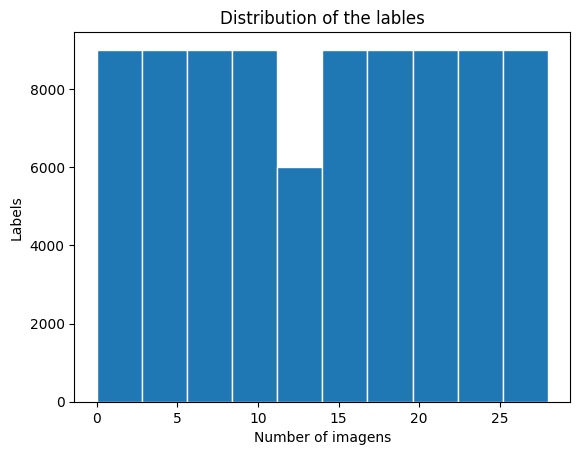

In [10]:
fig, ax = plt.subplots()
ax.hist(y, edgecolor = "white")
plt.title('Distribution of the lables')
plt.xlabel('Number of imagens')
plt.ylabel('Labels')

In [11]:
print("The shape of X is : ", X.shape)
print("The shape of y is : ", y.shape)

The shape of X is :  (87000, 64, 64, 3)
The shape of y is :  (87000,)


We then decided to look at the photos to observe each sign. We plotted only one image per sign, but the fold contains multiple photos of each sign.

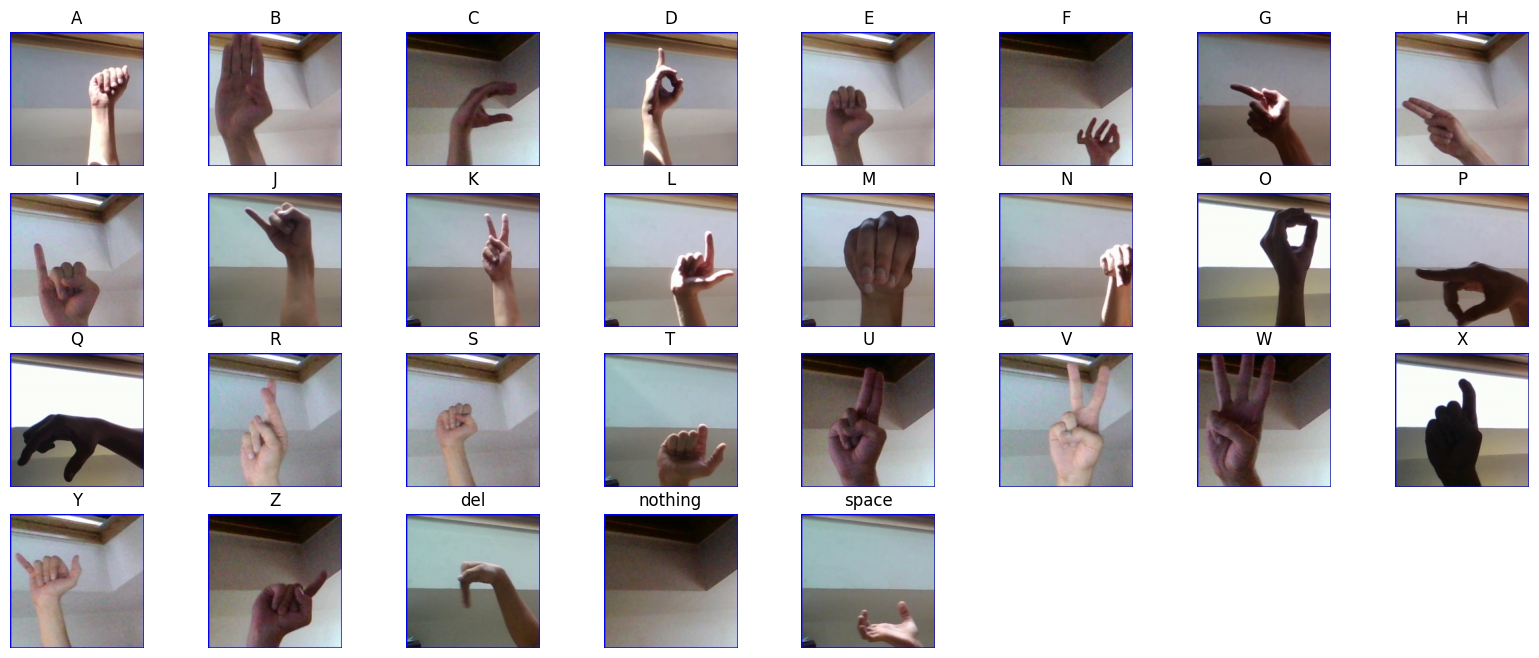

In [12]:
data_dir = Path(data)
signs = os.listdir(data_dir)
signs.sort()

plt.figure(figsize = (20, 8))
for i, sign in enumerate(signs):
    d = random.choice(list((data_dir / sign).glob('*.jpg')))
    ax = plt.subplot(4, 8, i + 1)
    img = image.imread(d)
    plt.imshow(img)
    plt.title(sign)
    plt.axis("off")

Finally, we want to observe how the program interprets the images. For that, we plot a histogram of RGB Pixel Intensity.

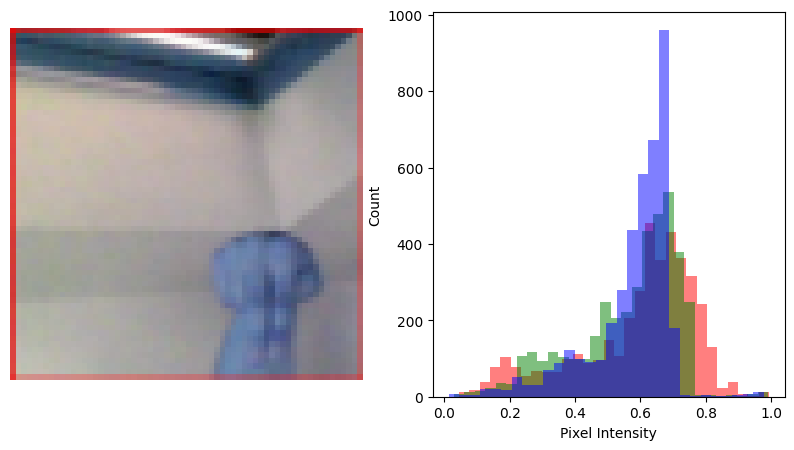

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(X[1])
plt.axis('off')
histo = plt.subplot(1,2,2)
histo.set_ylabel('Count')
histo.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(X[1][:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(X[1][:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(X[1][:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

## Modeling
We then start to create our model. First, we split the data into train and test, with the intention of using the test portion as validation. Our divison was 80/20. We then convert our labels from numerical to categorical.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

We then start creating a sequential model and adding layers to it.

In [15]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(29, activation='softmax') # 29 classes
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │        29,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,524,253 (36.33 MB)

 Trainable params: 9,524,253 (36.33 MB)

 Non-trainable params: 0 (0.00 B)

We then choose our optimizer and loss. Since we use categorical labels that aren't binary, we opted for a Categorical cross-entropy loss and used the Adam optimizer. We train our data using ten-epoch.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 408s 187ms/step - accuracy: 0.5844 - loss: 1.4190 - val_accuracy: 0.9810 - val_loss: 0.0674
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 400s 184ms/step - accuracy: 0.9760 - loss: 0.0795 - val_accuracy: 0.9818 - val_loss: 0.0608
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 394s 181ms/step - accuracy: 0.9864 - loss: 0.0503 - val_accuracy: 0.9954 - val_loss: 0.0169
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 415s 191ms/step - accuracy: 0.9928 - loss: 0.0286 - val_accuracy: 0.9890 - val_loss: 0.0359
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 407s 187ms/step - accuracy: 0.9924 - loss: 0.0274 - val_accuracy: 0.9938 - val_loss: 0.0218
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 395s 182ms/step - accuracy: 0.9958 - loss: 0.0165 - val_accuracy: 0.9880 - val_loss: 0.0645
Epoch 7/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 418s 192ms/step - accuracy: 0.9939 - loss: 0.0236 - val_accuracy: 0.9957 - val_loss: 0.0151
Epoch 8/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 434s 189ms/step - accuracy: 0.9

Considering the model's high precision level, we believe it is fully optimized, so we decided to plot the accuracy and loss levels over each epoch.

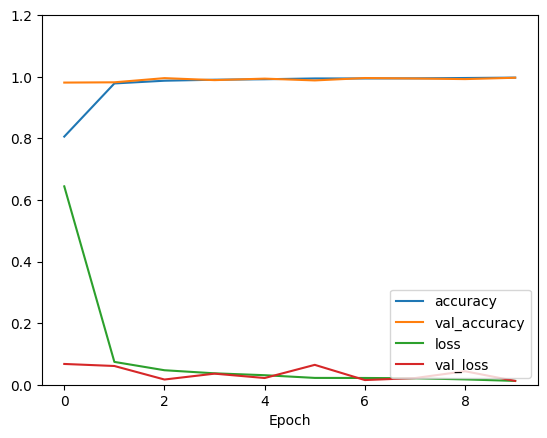

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylim([0.0, 1.2])
plt.legend(loc='lower right')

In [19]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

544/544 - 17s - 31ms/step - accuracy: 0.9967 - loss: 0.0123
0.996666669845581


## Testing
Finally, we evaluated the final model compared to the test fold, which contained new images that the algorithm had never seen before. 

In [20]:
def get_data2(folder):
    target_dims = (64, 64, 3)
    
    # List to store images and labels temporarily
    X_list = []
    y_list = []
    
    label_map = {
        'A_test': 0, 'B_test': 1, 'C_test': 2, 'D_test': 3, 'E_test': 4, 
        'F_test': 5, 'G_test': 6, 'H_test': 7, 'I_test': 8, 'J_test': 9, 
        'K_test': 10, 'L_test': 11, 'M_test': 12, 'N_test': 13, 'O_test': 14, 
        'P_test': 15, 'Q_test': 16, 'R_test': 17, 'S_test': 18, 'T_test': 19, 
        'U_test': 20, 'V_test': 21, 'W_test': 22, 'X_test': 23, 'Y_test': 24, 
        'Z_test': 25, 'del_test': 26, 'nothing_test': 27, 'space_test': 28
    }
    
    for file_name in os.listdir(folder):
        if not file_name.startswith('.'):
            # Extract the label from the file name (remove extension if needed)
            base_name = os.path.splitext(file_name)[0]
            label = label_map.get(base_name, None)
            
            if label is not None:
                img_file = cv2.imread(os.path.join(folder, file_name))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, target_dims)
                    X_list.append(img_file)
                    y_list.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=int)
    
    return X, y

In [21]:
data = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/'
X2, y2 = get_data2(data)

In [22]:
loss, accuracy = model.evaluate(X2, y2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 1.0766e-04


## Conclusions
As we can observe, the model is fully optimized against the images that were trained on and the new set of information. It is a good beginning for a developer who wants to create a translator from sign language to writing and vice versa. It is important to remember that in ASL, different words have different signs; they do not spell each letter to form a word. We would need a more extensive library of images to create a precise translator. We hope to use a similar CNN model to achieve this goal.

## References
Akash Nagaraj. (2018). ASL Alphabet [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/29550

https://www.kaggle.com/code/namanmanchanda/asl-detection-99-accuracy

https://www.kaggle.com/code/nguyencangtruong/customcnn-asl-alphabet/notebook

https://www.tensorflow.org/tutorials/images/cnn

https://www.kaggle.com/code/paultimothymooney/interpret-sign-language-with-deep-learning